# Streaky-ness 🔥

🏀 In this doc, I've created a new data set gathering each player's streaks per game. I worked from the [raw shot logs data in this repo](https://github.com/jessimk/LBJ_Make_or_Miss/blob/master/data/shot_logs_raw.csv).

📚 Part of the fun here has been continued practice with dictionaries and pandas. There's also EDA for the most 🔥 players, sorted by streak type. 

TODO:

The next addition here will be moving forward with some hypothesis testing and possibly some interactive plots.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

/Users/js/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Wrangling


In [3]:
data = pd.read_csv("../data/shot_logs_raw.csv")

In [5]:

#filling in buzzer shots in the shot clock col
data = data.fillna(0)
data.head(5)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [ ]:
data.describe()

#### Wrangling Streaks

In [15]:
def calc_streak(data):
    
    streak = []
    count = 0
    iteration = 0
    
    for shot in data:
        iteration +=1
        
        if iteration == len(data) and shot == 1:
            count +=1
            streak.append(count)
        
        elif shot == 1:
            count +=1

        elif shot == 0:

            streak.append(count)
            count = 0
            
    return streak

In [89]:
%%time
game_streaks = {}
for player in data["player_name"].unique():
    
    game_streaks[player] = {}
    
    for game in data[(data.player_name == player)]["GAME_ID"].unique():

        game_shots = list(data[(data.player_name == player) &
                               (data.GAME_ID == game)
                              ]['FGM'])

        game_streaks[player][game] = {"name":player,
                                      "game":game,
                                      "shots" : game_shots,
                                      "FGA": len(game_shots),
                                      "FGM": sum(game_shots),
                                      "W" : data[(data.GAME_ID == game)].W.values[0],
                                      "first_shot": game_shots[0]
                                     }
        streaks_tmp = calc_streak(game_shots)
        shot_streak, total = np.unique(streaks_tmp, return_counts=True)

        streaks_tmp_dict = dict(zip(shot_streak, total))

        for k,v in streaks_tmp_dict.items():
            if k == 0 or k == 1:
                pass
            else:
                col_name = str(k)+"_streak"
                game_streaks[player][game][col_name] = v

    
    

CPU times: user 2min 40s, sys: 1.15 s, total: 2min 41s
Wall time: 2min 44s


In [178]:
frames = []

for player in data["player_name"].unique():
    frames.append(pd.DataFrame(game_streaks[player]).T)

In [179]:
streaks = pd.concat(frames, sort=True)
streaks = streaks.fillna(0)

In [180]:
streaks = streaks[(streaks.FGA > 1) & (streaks.FGA > 1)]

In [181]:
streaks.head()

,10_streak,11_streak,13_streak,14_streak,2_streak,3_streak,4_streak,5_streak,6_streak,7_streak,8_streak,9_streak,FGA,FGM,W,first_shot,game,name,shots
21400899,0,0,0,0,0,0,0,0,0,0,0,0,9,2,W,1,21400899,brian roberts,"[1, 0, 0, 0, 0, 0, 0, 1, 0]"
21400890,0,0,0,0,1,0,0,0,0,0,0,0,4,2,W,0,21400890,brian roberts,"[0, 0, 1, 1]"
21400859,0,0,0,0,0,0,0,0,0,0,0,0,5,2,L,0,21400859,brian roberts,"[0, 1, 0, 0, 1]"
21400845,0,0,0,0,2,0,0,0,0,0,0,0,8,5,W,0,21400845,brian roberts,"[0, 1, 1, 0, 1, 0, 1, 1]"
21400827,0,0,0,0,0,0,0,0,0,0,0,0,4,0,L,0,21400827,brian roberts,"[0, 0, 0, 0]"


#### Streaky-ness EDA

In [203]:
n_shots = pd.DataFrame(streaks.groupby('name')['FGA'].sum())
made_shots = pd.DataFrame(streaks.groupby('name')['FGM'].sum())

In [204]:
total_2s = pd.DataFrame(streaks.groupby('name')["2_streak"].sum())
total_2s.columns = ['total_streaks']

mean_2streak = streaks.groupby('name')["2_streak"].mean()
mean_2streak = pd.DataFrame(mean_2streak)

mean_2streak = pd.concat([mean_2streak,total_2s,n_shots, made_shots], axis=1).sort_values(by="2_streak", ascending=False)

mean_2streak.head(10)

,2_streak,total_streaks,FGA,FGM
name,,,,
russell westbrook,1.565217,72,969,422
lebron james,1.490196,76,978,478
carmelo anthony,1.435897,56,792,349
demarcus cousins,1.400000,63,788,366
lamarcus aldridge,1.384615,72,1050,473
al jefferson,1.260000,63,800,382
james harden,1.237288,73,1054,474
damian lillard,1.220339,72,986,426
stephen curry,1.206897,70,968,470


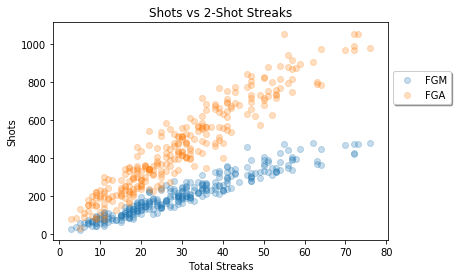

In [236]:
plt.scatter(mean_2streak.total_streaks, 
            mean_2streak.FGM, alpha=0.25,
           label="FGM")

plt.scatter(mean_2streak.total_streaks, 
            mean_2streak.FGA, alpha=0.25,
           label="FGA")

plt.legend(loc='upper center', 
           bbox_to_anchor=(1.1, 0.8), 
           shadow=True, ncol=1)

plt.xlabel("Total Streaks")
plt.ylabel("Shots")

plt.title("Shots vs 2-Shot Streaks")

plt.show()

In [206]:
total_3s = pd.DataFrame(streaks.groupby('name')["3_streak"].sum())
total_3s.columns = ['total_streaks']

mean_3streak = streaks.groupby('name')["3_streak"].mean()
mean_3streak = pd.DataFrame(mean_3streak)

mean_3streak = pd.concat([mean_3streak,total_3s, n_shots, made_shots], axis=1).sort_values(by="3_streak", ascending=False)

mean_3streak.head(10)

,3_streak,total_streaks,FGA,FGM
name,,,,
anthony davis,0.734694,36,841,457
blake griffin,0.705882,36,893,447
klay thompson,0.603448,35,971,449
lebron james,0.588235,30,978,478
stephen curry,0.586207,34,968,470
lamarcus aldridge,0.576923,30,1050,473
russell westbrook,0.565217,26,969,422
derrick favors,0.553571,31,677,369
kawhi leonard,0.547619,23,516,232


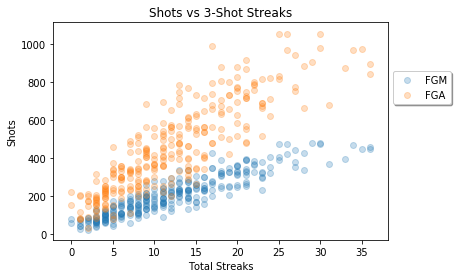

In [235]:
plt.scatter(mean_3streak.total_streaks, 
            mean_3streak.FGM, alpha=0.25,
           label="FGM")

plt.scatter(mean_3streak.total_streaks, 
            mean_3streak.FGA, alpha=0.25,
           label="FGA")

plt.legend(loc='upper center', 
           bbox_to_anchor=(1.1, 0.8), 
           shadow=True, ncol=1)

plt.xlabel("Total Streaks")
plt.ylabel("Shots")
plt.title("Shots vs 3-Shot Streaks")


plt.show()

In [207]:
total_4s = pd.DataFrame(streaks.groupby('name')["4_streak"].sum())
total_4s.columns = ['total_streaks']

mean_4streak = streaks.groupby('name')["4_streak"].mean()
mean_4streak = pd.DataFrame(mean_4streak)

mean_4streak = pd.concat([mean_4streak,total_4s, n_shots, made_shots], axis=1).sort_values(by="4_streak", ascending=False)

mean_4streak.head(10)

,4_streak,total_streaks,FGA,FGM
name,,,,
nikola vucevic,0.410714,23,902,480
chris paul,0.306452,19,885,425
joe johnson,0.280702,16,767,335
damian lillard,0.271186,16,986,426
tyson chandler,0.264151,14,338,229
al horford,0.263158,15,715,387
markieff morris,0.258065,16,830,388
james harden,0.254237,15,1054,474
chris bosh,0.250000,11,745,343


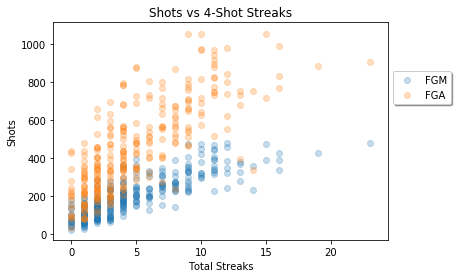

In [234]:
plt.scatter(mean_4streak.total_streaks, 
            mean_4streak.FGM, alpha=0.25,
           label="FGM")

plt.scatter(mean_4streak.total_streaks, 
            mean_4streak.FGA, alpha=0.25,
           label="FGA")

plt.legend(loc='upper center', 
           bbox_to_anchor=(1.1, 0.8), 
           shadow=True, ncol=1)

plt.xlabel("Total Streaks")
plt.ylabel("Shots")
plt.title("Shots vs 4-Shot Streaks")

plt.show()

In [208]:
total_5s = pd.DataFrame(streaks.groupby('name')["5_streak"].sum())
total_5s.columns = ['total_streaks']

mean_5streak = streaks.groupby('name')["5_streak"].mean()
mean_5streak = pd.DataFrame(mean_5streak)

mean_5streak = pd.concat([mean_5streak,total_5s, n_shots, made_shots], axis=1).sort_values(by="5_streak", ascending=False)

mean_5streak.head(10)

,5_streak,total_streaks,FGA,FGM
name,,,,
carmelo anthony,0.205128,8,792,349
anthony davis,0.183673,9,841,457
amare stoudemire,0.179487,7,336,185
rudy gay,0.166667,9,878,391
brook lopez,0.163265,8,631,308
mnta ellis,0.147541,9,1051,473
jordan hill,0.145455,8,614,285
nikola vucevic,0.142857,8,902,480
deandre jordan,0.129032,8,393,280


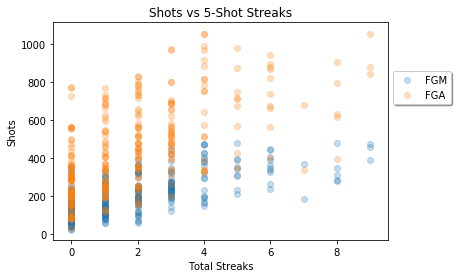

In [233]:
plt.scatter(mean_5streak.total_streaks, 
            mean_5streak.FGM, alpha=0.25,
           label="FGM")

plt.scatter(mean_5streak.total_streaks, 
            mean_5streak.FGA, alpha=0.25,
           label="FGA")

plt.legend(loc='upper center', 
           bbox_to_anchor=(1.1, 0.8), 
           shadow=True, ncol=1)

plt.xlabel("Total Streaks")
plt.ylabel("Shots")
plt.title("Shots vs 5-Shot Streaks")


plt.show()